<a href="https://colab.research.google.com/github/NiallJeffrey/post-Newtonian/blob/master/solar_system_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy as np
import numpy as onp
from jax import jit
from jax.experimental.ode import odeint
from jax.ops import index, index_add, index_update
from jax.config import config
config.update("jax_enable_x64", True)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print('(GPU is often slower)')

cpu
(GPU is often slower)


In [2]:
@jit 
def acceleration_vector(r, Gm):
    return -Gm*r* (np.linalg.norm(r)**(-3))

@jit
def dydt(y,t,Gm):
  n_objects = len(Gm)
  r, v = y.reshape((2,n_objects,3))
  a = np.zeros(v.shape)

  # Loop over each i object to calculate forces
  for i in range(n_objects):
    # Sum over other j object contributions
    for j in range(n_objects):
      if i!=j: 
        a = index_add(a, index[i,:],acceleration_vector(r[i]-r[j], Gm[j]))

  return np.concatenate([v.flatten(), a.flatten()])
    

In [19]:
def read_orbit(name, path):
    ''' Reads the data for a single orbit
    Parameters: 
    -----------
    name: str
        the name of the body
    path: string
        the path to the orbit file

    Returns: 
    --------
    orbit_data : np.array
        a numpy array containing the positions and accelerations for the body 
    '''
    try:
        orbit = onp.loadtxt(path+name+'.txt', usecols = [2,3,4,5,6,7], 
                            unpack=True, delimiter=',')
    except IndexError:
        orbit = np.genfromtxt(path+name+'.txt', usecols = [2,3,4,5,6,7], 
                            unpack=True, delimiter=',',
                            skip_header=22, skip_footer = 31
                            )

    return orbit

def add_moons(name, orbits_ls, masses_ls, names_ls, use_moons, path):
    ''' If not using moons, corrects the orbit by changing it to the center 
    of mass of the planet + moons system. Else, add the moons to the list of 
    orbits
    Parameters: 
    -----------
    name: str
        the name of the planet
    orbits_ls : ls
        a list containing the orbits data
    masses_ls : ls
        the masses of all bodies
    names_ls : ls
        the names of all bodies
    use_moons: bool
        whether to treat the moons as separate bodies.
    path: string
        the path to the orbit files

    Returns: 
    --------
    orbits_ls : ls
        a list containing the updated orbits data 
    masses_ls : ls
        the masses of all bodies
    names_ls : ls
        the names of all bodies
    '''   
    # Check if the planets has moons
    if name in planets_with_moons:
        i = planet_names.index(name)
        j = planets_with_moons.index(name)
        for (moon, mass_moon) in zip(moon_names[j],moon_masses[j]):
            orbit_moon = read_orbit(moon, path)
            # If the moons are not being treated as separate bodies, we change
            # the orbit of the planets by the orbit of the Center of Mass of 
            # the planet and orbit system. 
            if use_moons == False:
                #print('Adding data for', moon)
                orbits_ls[-1] += orbit_moon*mass_moon/planet_masses[i]

            # Else, add each moon
            else:
                print('Reading data for', moon)
                orbits_ls.append(orbit_moon)
                masses_ls.append(mass_moon)
                names_ls.append(moon)

    
    return orbits_ls, masses_ls, names_ls


def read_orbits_main(nplanets = 0, 
              use_moons = False, 
              frame = 'b', 
              path = './nasa_orbits/'):
    ''' Reads the data files and returns a numpy array with the orbits 
    Parameters: 
    -----------
    nplanets: int
        the number of planets to be used. If 0, use all the planets. 
        Defaults to 0
    use_moons: bool
        whether to treat the moons as separate bodies. Defaults to False
    frame: str
        The frame of reference to be used. Options are 'b' (barycenter) or 
        's' (sun_center). Defaults to 'barycenter'
    path: string
        the path to the orbit files. It should contain two folders: 'barycenter'
        and 'sun_center'

    Returns: 
    --------
    orbits_data : np.array()
        a numpy array containing the positions and accelerations for each 
        body.
    masses : np.array()
        the masses of all bodies
    names_ls : ls
        the names of all bodies
    '''

    # Modify the path to include the reference frame
    if frame[0]=='b':
        print('Reading data in Solar System barycenter reference frame')
        path += 'barycenter/'
    elif frame[0]=='s':
        print('Reading data in Sun reference frame. Known masses will then be', \
            'used to move to barycenter frame of used bodies. Use this only for', \
            'testing and when few bodies are being used.')
        path += 'sun_center/'    
    else: 
        raise ValueError("frame must be 'b' (barycenter) or 's' (sun_center).")

    # If using the default value for nplanets, we use all 8
    if nplanets == 0: 
        nplanets = 8

    # Read the sun's orbit
    orbit_sun = read_orbit('sun', path)
    # Create a list that will contain all the orbits
    orbits_ls = [orbit_sun]
    # Create a list that will contain all the masses
    masses_ls = [sun_mass]
    names_ls = ['sun']

    for i in range(nplanets):
        name = planet_names[i]
        print('Reading data for', name)
        orbit = read_orbit(name, path)
        orbits_ls.append(orbit)
        masses_ls.append(planet_masses[i])
        names_ls.append(name)
        orbits_ls, masses_ls, names_ls = add_moons(name, orbits_ls, masses_ls,
                                         names_ls, use_moons, path)

    orbits_data = np.stack(orbits_ls)
    # Transpose to get an array with time, planet, axes
    # orbits_data = orbits_data.transpose(2,0,1)
    
    # Convert list of masses to numpy array
    masses = np.asarray(masses_ls)

    print('Finished reading data')
    print('The data array contains', len(orbits_data[0]), 'bodies.')

    # If the frame is sub center, need to change things.
    if frame[0] == 's':
        print("Changing frame of reference (this only happens when the data", \
           "is loaded in the Sun's frame). ")
        # Change frame of reference to the barycenter of the planets we are using
        P = masses[np.newaxis, :, np.newaxis]*orbits_data[:,:,3:] 
        V_ref = np.sum(P, axis = 1,keepdims=True)/np.sum(masses)
        orbits_data[:,:,3:] -= V_ref

    return orbits_data, masses, names_ls

# Data

In [3]:
sun_mass = 1.9885e+30

planet_names = ['mercury', 
                'venus',
                'earth', 
                'mars',
                'jupiter',
                'saturn', 
                'uranus', 
                'neptune', 
                ]

planet_masses = [0.33011 * 10**24, 
                4.8685 * 10**24,
                5.9724 * 10**24, 
                0.64171 * 10**24,
                1898.19 * 10**24,
                568.34 * 10**24, 
                86.8103 * 10**24, 
                102.41 * 10**24, 
                ]

planets_with_moons = ['earth', 
                'mars',
                'jupiter',
                'saturn', 
                'uranus', 
                'neptune', 
                ]


earth_moon_names = ['moon']

earth_moon_masses = [0.0734767309 * 10**24]

mars_moon_names = ['phobos', 
                   'deimos']

mars_moon_masses = [1.0659 * 10**16,
                   1.4762 * 10**15
]

jupiter_moon_names = ['io', 
                     'europa', 
                     'ganymede', 
                     'callisto', 
                    ]

jupiter_moon_masses = [0.08931900 * 10**24, 
                            0.048 * 10**24, 
                            0.14819 * 10**24,
                            0.10759 * 10**24]

saturn_moon_names = ['mimas', 
                     'enceladus', 
                     'tethys', 
                     'dione', 
                     'rhea', 
                     'titan', 
                     'hyperion', 
                     'iapetus',
                     'phoebe',
                     ]

saturn_moon_masses = [0.000037493 * 10**24, 
                     0.000108022 * 10**24, 
                     0.000617449 * 10**24, 
                     0.001095452 * 10**24, 
                     0.002306518 * 10**24, 
                     0.1353452 * 10**24, 
                     5.6199 * 10**18, 
                     0.001805635 * 10**24,
                     8.292 * 10**18,
                     ]

uranus_moon_names = ['ariel', 
                     'umbriel', 
                     'titania', 
                     'oberon',
                     'miranda', 
                    ]

uranus_moon_masses = [125100. * 10**16, 
                            127500. * 10**16, 
                            340000. * 10**16,
                            307600. * 10**16,
                            6400.* 10**16,
                            ]

neptune_moon_names = ['triton', 
                      'nereid',
                      'proteus',
                    ]

neptune_moon_masses = [2139000. * 10**16,
                       3.0873 * 10**19,
                       4.4 * 10**19 
]
                            

moon_names = [earth_moon_names, 
                   mars_moon_names,
                   jupiter_moon_names,
                   saturn_moon_names,
                   uranus_moon_names,
                   neptune_moon_names,
]
        
moon_masses = [earth_moon_masses, 
                   mars_moon_masses,
                   jupiter_moon_masses,
                   saturn_moon_masses,
                   uranus_moon_masses,
                   neptune_moon_masses,
                   ]

In [4]:
import os 
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
print(os.chdir('/content/drive/My Drive'))
!ls /content/drive/MyDrive/barycenter

Mounted at /content/drive
None
ariel.txt      europa.txt    mars.txt	  nereid.txt   saturn.txt   umbriel.txt
callisto.txt   ganymede.txt  mercury.txt  oberon.txt   sun.txt	    uranus.txt
deimos.txt     hyperion.txt  mimas.txt	  phobos.txt   tethys.txt   venus.txt
dione.txt      iapetus.txt   miranda.txt  phoebe.txt   titania.txt
earth.txt      io.txt	     moon.txt	  proteus.txt  titan.txt
enceladus.txt  jupiter.txt   neptune.txt  rhea.txt     triton.txt


In [6]:
object_file_names = os.listdir('/content/drive/MyDrive/barycenter')

In [8]:
n_objects = len(object_file_names)

In [105]:
AU = 149.6e6 * 1000 # Astronomical Unit in meters.
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (0.5/24.) # 2 hours
MSUN = 1.9885e+30
MEARTH = 5.9724e+24
G = 6.67428e-11/AU**3*MSUN*DAY**2


# Read the data
nplanets = 8 # Number of planets (not counting the sun)
data, masses, names = read_orbits_main(nplanets = nplanets, frame='b', use_moons = True, 
                                       path='/content/drive/MyDrive/')
nplanets = len(data[0])
nedges = nplanets*(nplanets-1)//2

Reading data in Solar System barycenter reference frame
Reading data for mercury
Reading data for venus
Reading data for earth
Reading data for moon
Reading data for mars
Reading data for phobos
Reading data for deimos
Reading data for jupiter
Reading data for io
Reading data for europa
Reading data for ganymede
Reading data for callisto
Reading data for saturn
Reading data for mimas
Reading data for enceladus
Reading data for tethys
Reading data for dione
Reading data for rhea
Reading data for titan
Reading data for hyperion
Reading data for iapetus
Reading data for phoebe
Reading data for uranus
Reading data for ariel
Reading data for umbriel
Reading data for titania
Reading data for oberon
Reading data for miranda
Reading data for neptune
Reading data for triton
Reading data for nereid
Reading data for proteus
Finished reading data
The data array contains 6 bodies.


In [125]:
masses

DeviceArray([1.98850000e+30, 3.30110000e+23, 4.86850000e+24,
             5.97240000e+24, 7.34767309e+22, 6.41710000e+23,
             1.06590000e+16, 1.47620000e+15, 1.89819000e+27,
             8.93190000e+22, 4.80000000e+22, 1.48190000e+23,
             1.07590000e+23, 5.68340000e+26, 3.74930000e+19,
             1.08022000e+20, 6.17449000e+20, 1.09545200e+21,
             2.30651800e+21, 1.35345200e+23, 5.61990000e+18,
             1.80563500e+21, 8.29200000e+18, 8.68103000e+25,
             1.25100000e+21, 1.27500000e+21, 3.40000000e+21,
             3.07600000e+21, 6.40000000e+19, 1.02410000e+26,
             2.13900000e+22, 3.08730000e+19, 4.40000000e+19],            dtype=float64)

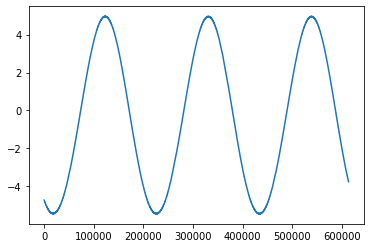

In [124]:
plt.plot(data[12,0,:])

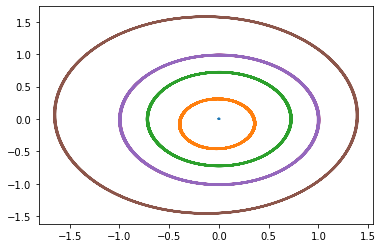

In [116]:
for i in range(6):
  plt.plot(data[i,0,:],data[i,1,:])

In [59]:
from astropy.time import Time
from astropy import constants as const
from astropy import units as u

In [128]:
Gm_planets

DeviceArray([1.32718455e+20, 2.20325317e+13, 3.24938295e+14,
             3.98615893e+14, 4.90405745e+12, 4.28296505e+13,
             7.11413637e+05, 9.85260166e+04, 1.26690895e+17,
             5.96141802e+12, 3.20366400e+12, 9.89064517e+12,
             7.18087937e+12, 3.79327166e+16, 2.50239530e+09,
             7.20971235e+09, 4.12103986e+10, 7.31137528e+10,
             1.53943931e+11, 9.03334468e+12, 3.75088986e+08,
             1.20513497e+11, 5.53432956e+08, 5.79397985e+15,
             8.34954930e+10, 8.50973250e+10, 2.26926200e+11,
             2.05301468e+11, 4.27155200e+09, 6.83515063e+15,
             1.42763277e+12, 2.06055664e+09, 2.93669200e+09],            dtype=float64)

In [126]:
Gm_planets

DeviceArray([1.32716453e+20, 2.20251900e+13, 3.25038410e+14,
             4.03327949e+14, 4.28490060e+13, 1.26678214e+17,
             3.79100240e+16, 5.79329240e+15, 6.80778600e+15],            dtype=float64)

In [129]:
# masses = [1.98847e6,0.330, 4.87,5.97 +	0.073,	0.642,	1898.,	568.,	86.8,	102]
Gm_planets = np.array(masses)*const.G
day = 86400.


In [130]:
y0_solar_system_planets.shape

(54,)

In [131]:
y0_solar_system_planets = np.concatenate([data[:,:3,0].flatten() * const.au.value , data[:,3:,0].flatten() * const.au.value /day])

In [ ]:
tsteps = np.linspace(0, day*(365*4+1), 200000)
%time solar_planet_result_r, solar_planet_result_v = odeint(dydt, y0_solar_system_planets, tsteps, Gm_planets, rtol=1e-11).T.reshape(2,len(Gm_planets),3, len(tsteps))

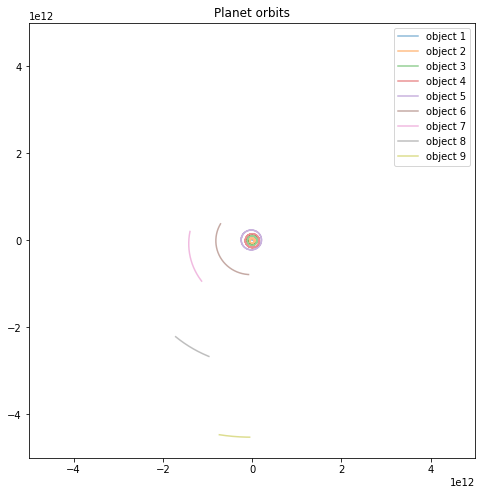

In [69]:
_ = plt.figure(figsize=(8,8)), plt.ylim(-5e12,5e12), plt.xlim(-5e12,5e12)
for i in range(len(Gm_planets)): _ = plt.plot(solar_planet_result_r[i,0],solar_planet_result_r[i,1],
                                  label = 'object ' + str(i+1), alpha=0.5)
_ =  plt.title('Planet orbits'), plt.legend()

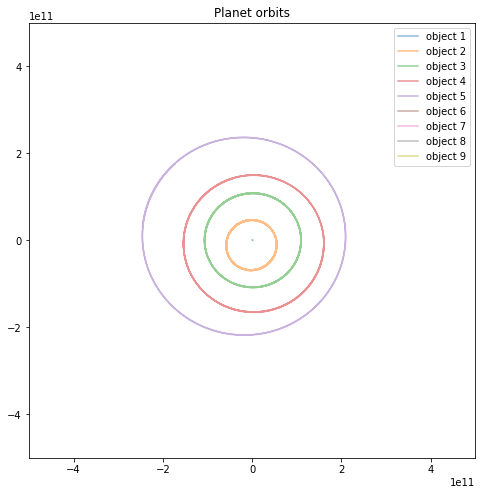

In [72]:
_ = plt.figure(figsize=(8,8)), plt.ylim(-5e11,5e11), plt.xlim(-5e11,5e11)
for i in range(len(Gm_planets)): _ = plt.plot(solar_planet_result_r[i,0],solar_planet_result_r[i,1],
                                  label = 'object ' + str(i+1), alpha=0.5)
_ =  plt.title('Planet orbits'), plt.legend()

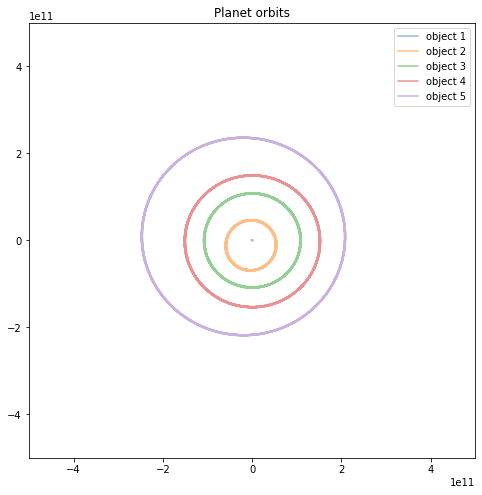

In [75]:
_ = plt.figure(figsize=(8,8)), plt.ylim(-5e11,5e11), plt.xlim(-5e11,5e11)
for i in range(5): _ = plt.plot(data[i,0,:]* const.au.value,data[i,1,:]* const.au.value,
                                  label = 'object ' + str(i+1), alpha=0.5)
_ =  plt.title('Planet orbits'), plt.legend()

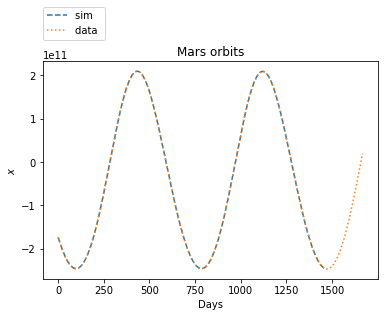

In [103]:
_ = plt.plot(tsteps/day, solar_planet_result_r[4,0,:] ,label = 'sim ', ls='--' )
_ = plt.plot(np.arange(len(data[4,0,:80000]))*delta_time,data[4,0,:80000]*const.au.value,label = 'data ' ,ls=':' ), plt.ylabel(r'$x$')
_ =  plt.title('Mars orbits'), plt.legend(loc=(0,1.1)), plt.xlabel('Days')

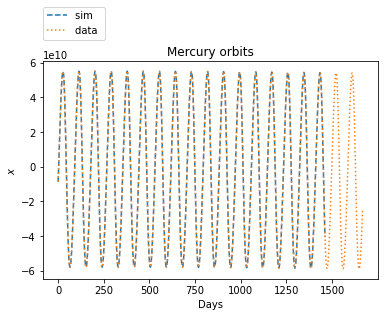

In [104]:
_ = plt.plot(tsteps/day, solar_planet_result_r[1,0,:] ,label = 'sim ', ls='--' )
_ = plt.plot(np.arange(len(data[1,0,:80000]))*delta_time,data[1,0,:80000]*const.au.value,label = 'data ' ,ls=':' ), plt.ylabel(r'$x$')
_ =  plt.title('Mercury orbits'), plt.legend(loc=(0,1.1)), plt.xlabel('Days')